In [55]:
import numpy as np 
import pandas as pd
import os
from datetime import datetime
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
import geopandas as gpd
import matplotlib.colors as mcolors

In [56]:

class CatchesSSTCorrelator:
    def __init__(self, data_dir):
        self.data_dir = Path(data_dir)
        self.catches_data = pd.DataFrame()
        self.sst_data = xr.Dataset()
        self.sst_weekly = xr.Dataset()
        self.sst_df = pd.DataFrame()
        self.merge_datasets = pd.DataFrame()
        self.results = pd.DataFrame()
        self.grouped = pd.DataFrame()
        
    def load_catches_data(self, filename):
        self.catches_data = pd.read_csv(self.data_dir / filename)

    def load_sst_data(self, filepath):
        self.sst_data = xr.open_dataset(filepath)

    def preprocess_catches_data(self):
        def parse_temporada(row):
            parte, anio = row.split()
            return int(anio)
        self.catches_data["anio"] = self.catches_data["temporada"].apply(parse_temporada)
        self.catches_data["fecha"] = pd.to_datetime(
            self.catches_data["anio"].astype(str), format="%Y"
        ) + pd.to_timedelta((self.catches_data["semana"] - 1) * 7, unit="D")

    def preprocess_sst_data(self):
        years = np.arange(2015, 2025)
        ds_list = []
        for y in years:
            ds_year = self.sst_data.sel(time=slice(f"{y}-01-01", f"{y}-12-31"))
            ds_year_weekly = ds_year.resample(time="7D", origin=f"{y}-01-01").max()            # media de SST semanal
            ds_list.append(ds_year_weekly)

        sst_weekly = xr.concat(ds_list, dim="time")

        semanas = sst_weekly["time"].dt.isocalendar().week
        mask_temporada1 = (semanas >= 14) & (semanas <= 32)
        mask_temporada2 = (semanas >= 42) | (semanas <= 5)
        mask_temporadas = mask_temporada1 | mask_temporada2

        self.sst_weekly = sst_weekly.where(mask_temporadas, drop=True)

    def convert_xarray_to_dataframe(self):
        if "sst" not in self.sst_weekly.data_vars:
            raise ValueError("El dataset no contiene la variable 'sst'")
        df = self.sst_weekly["sst"].to_dataframe().reset_index()
        df.rename(columns={"sst": "sst_anomaly"}, inplace=True)
        df["semana"] = df["time"].dt.isocalendar().week
        df.rename(columns={"lat": "lat_bin", "lon": "lon_bin", "time": "fecha"}, inplace=True)

        df["lat_bin"] = df["lat_bin"].round(5)
        df["lon_bin"] = df["lon_bin"].round(5)

        self.sst_df = df
    
    def merge_datasets_catches_sst(self):
        if self.catches_data.empty or self.sst_df.empty:
            raise ValueError("Ambos datasets deben estar cargados y preprocesados")
        merged = pd.merge(
            self.catches_data[["fecha", "lat_bin", "lon_bin", "suma_pescado", "temporada"]],
            self.sst_df[["fecha", "lat_bin", "lon_bin", "sst_anomaly"]],
            on=["fecha", "lat_bin", "lon_bin"],
            how="inner"
        )

        self.merge_datasets = merged[merged["suma_pescado"] != 0]
    

    def grouped_merged(self, step=3):

        merged = self.merge_datasets

        df = merged.copy()
        df["lat_idx"] = df["lat_bin"].rank(method="dense").astype(int)
        df["lon_idx"] = df["lon_bin"].rank(method="dense").astype(int)

        df["lat_block"] = (df["lat_idx"] // step)
        df["lon_block"] = (df["lon_idx"] // step)

        df["lat_center"] = df.groupby("lat_block")["lat_bin"].transform("mean")
        df["lon_center"] = df.groupby("lon_block")["lon_bin"].transform("mean")

        grouped = (
            df.groupby(["fecha","temporada","lat_block","lon_block"], as_index=False)
            .agg({
                "suma_pescado": "sum",
                "sst_anomaly": "max",              # media de SST en el bloque
                "lat_center": "first",
                "lon_center": "first"
            })
            .rename(columns={"lat_center": "lat_bin", "lon_center": "lon_bin"})
        )

        self.grouped = grouped

    def correlate(self):

        results = []
        grouped = self.grouped
        for (lat, lon), df_group in grouped.groupby(["lat_bin", "lon_bin"]):
            n_registros = df_group.shape[0]
            if n_registros > 21:
                corr = df_group[["suma_pescado", "sst_anomaly"]].corr().iloc[0,1]
                results.append({"lat": lat, "lon": lon, "correlation": corr, "n_registros": n_registros})
        self.results = pd.DataFrame(results)

    def save_results(self, output_filename):
        self.results.to_csv(self.data_dir / output_filename, index=False)


    def visualizar_correlacion(self, shapefile_path=None, mode="grid"):
    
        if self.results.empty:
            raise ValueError("Primero debes correr el método correlate()")

        fig = plt.figure(figsize=(8, 8))
        ax = plt.axes([0.05, 0.05, 0.85, 0.9])

        if shapefile_path:
            boundary = gpd.read_file(shapefile_path)
            boundary.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5)

        if mode == "scatter":
            sc = ax.scatter(
                self.results["lon"],
                self.results["lat"],
                c=self.results["correlation"],
                cmap="RdBu_r",
                vmin=-1, vmax=1,
                s=50
            )
            cbar = plt.colorbar(sc, ax=ax, label="Correlación")

        elif mode == "grid":
            grid = self.results.pivot_table(
                index="lat", columns="lon", values="correlation"
            )
            lons = grid.columns.values
            lats = grid.index.values
            Z = grid.values

            levels = np.linspace(-1, 1, 21)
            norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

            mesh = ax.pcolormesh(
                lons, lats, Z -0.05,
                cmap="RdBu_r", norm=norm,
                shading="auto"
            )

            cax = plt.axes([0.92, 0.1, 0.02, 0.8])

            plt.colorbar(mesh, cax=cax, ticks=levels, label="Correlación")

        else:
            raise ValueError("mode debe ser 'scatter' o 'grid'")

        ax.set_xlim([-83, -74.5])  # ajusta a tu dominio
        ax.set_ylim([-16, -4])
        ax.set_xlabel("Longitud")
        ax.set_ylabel("Latitud")
        ax.set_title("Mapa de correlación capturas–SST", fontsize=10, loc="left")

        plt.show()

#        fig.savefig(self.data_dir / "correlation_map.png", bbox_inches="tight", dpi=300)


In [57]:

data_dir = "/Users/daniela/Documents/suyana/peru_data_gobierno/data/output/"
sst_path = "/Users/daniela/Documents/suyana/peru_produccion/data/MODIS/processed/sst_anomaly_daily_2012_2024.nc"
csc = CatchesSSTCorrelator(data_dir)


In [58]:

csc.load_catches_data("calas_grillado_semanal.csv")
csc.load_sst_data(sst_path)
csc.preprocess_catches_data()
csc.preprocess_sst_data()
csc.convert_xarray_to_dataframe()
csc.merge_datasets_catches_sst()
csc.grouped_merged(step=2)
csc.correlate()

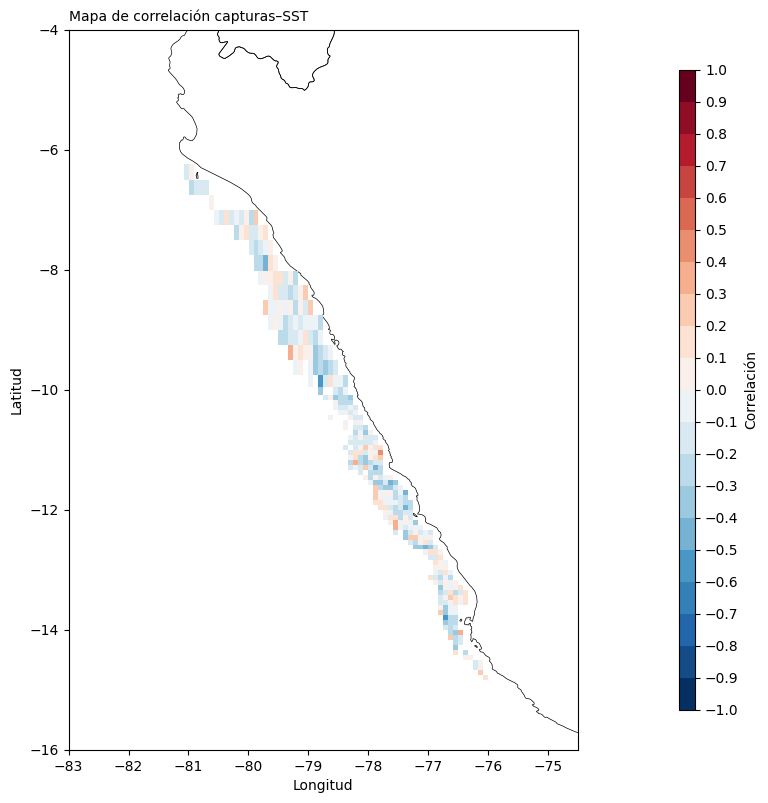

In [59]:

csc.visualizar_correlacion(
    shapefile_path="../data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp",
    mode="grid"
)